<a href="https://colab.research.google.com/github/falahamro/Deep-Learning/blob/main/Forest_Fires_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Forest Fire Prediction**

Given the weather conditions, predict if there is going to be forest fires in the future. 

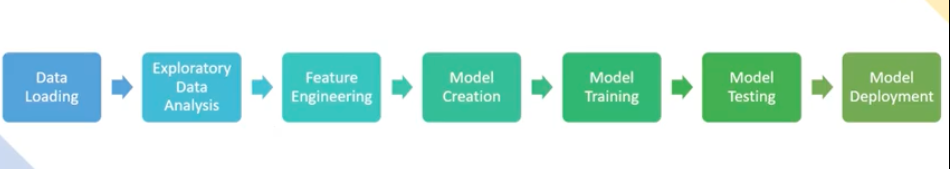

In [79]:
# Import required libraries and packages
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [80]:
# Read the Dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
dataset = pd.read_csv("/content/drive/MyDrive/Data Science Challenges /Forest Fires/Cleaned_dataset.csv")

In [82]:
dataset

,day,month,RH,Ws,Rain,FFMC,DMC,FWI,Classes,Temperature
0,1.0,6.0,57.0,18.0,0.0,65.7,3.4,0.5,1,29.0
1,2.0,6.0,61.0,13.0,1.3,64.4,4.1,0.4,1,29.0
2,3.0,6.0,82.0,22.0,13.1,47.1,2.5,0.1,1,26.0
3,4.0,6.0,89.0,13.0,2.5,28.6,1.3,0.0,1,25.0
4,5.0,6.0,77.0,16.0,0.0,64.8,3.0,0.5,1,27.0
...,...,...,...,...,...,...,...,...,...,...
238,26.0,9.0,65.0,14.0,0.0,85.4,16.0,6.5,0,30.0
239,27.0,9.0,87.0,15.0,4.4,41.1,6.5,0.0,1,28.0
240,28.0,9.0,87.0,29.0,0.5,45.9,3.5,0.2,1,27.0
241,29.0,9.0,54.0,18.0,0.1,79.7,4.3,0.7,1,24.0


Explaratory Data Analysis 

In [83]:
dataset.isnull().sum()

day            0
month          0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
FWI            0
Classes        0
Temperature    0
dtype: int64

In [84]:
dataset.dtypes

day            float64
month          float64
RH             float64
Ws             float64
Rain           float64
FFMC           float64
DMC            float64
FWI            float64
Classes          int64
Temperature    float64
dtype: object

In [85]:
# Finding categorical features
cat_features = dataset.select_dtypes(include=['object']).columns.tolist()
cat_features

[]

In [86]:
dataset.tail()

,day,month,RH,Ws,Rain,FFMC,DMC,FWI,Classes,Temperature
238,26.0,9.0,65.0,14.0,0.0,85.4,16.0,6.5,0,30.0
239,27.0,9.0,87.0,15.0,4.4,41.1,6.5,0.0,1,28.0
240,28.0,9.0,87.0,29.0,0.5,45.9,3.5,0.2,1,27.0
241,29.0,9.0,54.0,18.0,0.1,79.7,4.3,0.7,1,24.0
242,30.0,9.0,64.0,15.0,0.2,67.3,3.8,0.5,1,24.0


In [87]:
numerical_features = dataset.select_dtypes(exclude=['object']).columns.tolist()
numerical_features

['day',
 'month',
 'RH',
 'Ws',
 'Rain',
 'FFMC',
 'DMC',
 'FWI',
 'Classes',
 'Temperature']

In [88]:
for feature in cat_features:
  print('The feature is {} and cardinality of this feature -->{}'.format(feature, len(dataset[feature].unique())))

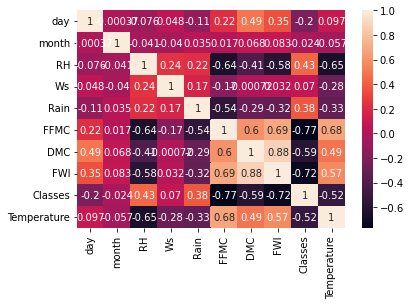

In [89]:
# Display correlations between variables
sns.heatmap(dataset.corr(), annot=True)
plt.show()

Outlier Detection

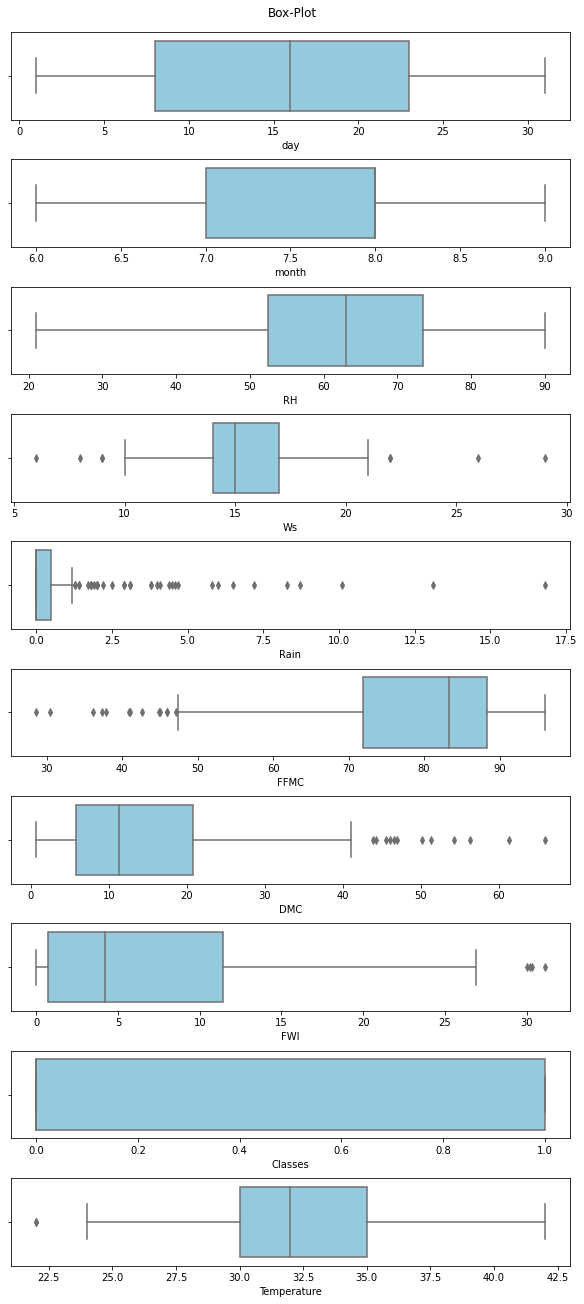

In [90]:
cols = dataset.select_dtypes(exclude='object').columns.tolist()

fig, ax = plt.subplots(nrows=10,ncols=1, figsize=(8,18), constrained_layout=True)
ax = ax.flatten()
plt.suptitle("Box-Plot")
for x, i in enumerate(cols):
    sns.boxplot(x=dataset[i], ax=ax[x], palette=['skyblue'])

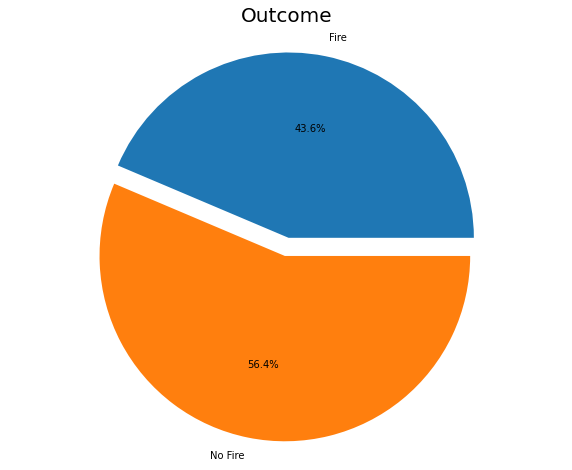

In [91]:
labels = 'Fire', 'No Fire'
sizes = [dataset.Classes[dataset['Classes']==1].count(), dataset.Classes[dataset['Classes']==0].count()]
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=(0, 0.1), labels=labels, autopct='%1.1f%%')
ax1.axis('equal')
plt.title("Outcome", size = 20)
plt.show()

In [92]:
### Way to Detect Outliers###
#Using box plot
#Using IQR (Inter Quartile Range)
#Using Z Score

Let's use the IQR Option for FFMC Feature from the data as an example

In [93]:
percentile25 = dataset['FFMC'].quantile(0.25)
percentile75 = dataset['FFMC'].quantile(0.75)
iqr = percentile75 - percentile25

In [94]:
print(iqr)

16.450000000000003


In [95]:
upper_limit = percentile75 + 1.5*iqr
lower_limit = percentile25 + 1.5*iqr

In [96]:
upper_limit

112.975

In [97]:
lower_limit

96.525

Find records betwwen upper and lower

In [98]:
record_beyond_upper = dataset['FFMC'] >= upper_limit
print(np.where(record_beyond_upper))

(array([], dtype=int64),)


In [99]:
records_below_limit = dataset['FFMC'] <= lower_limit
print(np.where(records_below_limit))

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 1

You can also use zscores to find outliers

In [100]:
#std = np.std(dataset['FFMC'])
#std

In [101]:
#mean = np.mean(dataset['FFMC'])
#mean

In [102]:
#z_score =[ (dataset.iloc[i, 5]-mean)/std for i in range(len(dataset)) ]

In [103]:
#z_score

In [104]:
#for item in z_score:
#  if (item >= 3.0 or item <= -3.0):
#    print(item)

**Feature Engineering**

In [105]:
dataset.dropna(axis=0, inplace=True)

In [106]:
dataset.isnull().sum()

day            0
month          0
RH             0
Ws             0
Rain           0
FFMC           0
DMC            0
FWI            0
Classes        0
Temperature    0
dtype: int64

Converting categorical columns to numerical

In [107]:
dataset = dataset.dropna(how = 'any')
dataset.fillna(0,inplace=True)
dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset.replace(np.nan, 0)

,day,month,RH,Ws,Rain,FFMC,DMC,FWI,Classes,Temperature
0,1.0,6.0,57.0,18.0,0.0,65.7,3.4,0.5,1,29.0
1,2.0,6.0,61.0,13.0,1.3,64.4,4.1,0.4,1,29.0
2,3.0,6.0,82.0,22.0,13.1,47.1,2.5,0.1,1,26.0
3,4.0,6.0,89.0,13.0,2.5,28.6,1.3,0.0,1,25.0
4,5.0,6.0,77.0,16.0,0.0,64.8,3.0,0.5,1,27.0
...,...,...,...,...,...,...,...,...,...,...
238,26.0,9.0,65.0,14.0,0.0,85.4,16.0,6.5,0,30.0
239,27.0,9.0,87.0,15.0,4.4,41.1,6.5,0.0,1,28.0
240,28.0,9.0,87.0,29.0,0.5,45.9,3.5,0.2,1,27.0
241,29.0,9.0,54.0,18.0,0.1,79.7,4.3,0.7,1,24.0


Dvide data into Independent Features (X) and Dependent feature (y)

In [108]:
# We're going to predict whether fire will occur or not

y = dataset['Classes']
y

0      1
1      1
2      1
3      1
4      1
      ..
238    0
239    1
240    1
241    1
242    1
Name: Classes, Length: 243, dtype: int64

In [109]:
independent_features = ['RH',	'Ws', 'Rain', 'FFMC', 'DMC', 'FWI', 'Temperature']

x = dataset[independent_features]

x

,RH,Ws,Rain,FFMC,DMC,FWI,Temperature
0,57.0,18.0,0.0,65.7,3.4,0.5,29.0
1,61.0,13.0,1.3,64.4,4.1,0.4,29.0
2,82.0,22.0,13.1,47.1,2.5,0.1,26.0
3,89.0,13.0,2.5,28.6,1.3,0.0,25.0
4,77.0,16.0,0.0,64.8,3.0,0.5,27.0
...,...,...,...,...,...,...,...
238,65.0,14.0,0.0,85.4,16.0,6.5,30.0
239,87.0,15.0,4.4,41.1,6.5,0.0,28.0
240,87.0,29.0,0.5,45.9,3.5,0.2,27.0
241,54.0,18.0,0.1,79.7,4.3,0.7,24.0


SCALING THE DATA TO BRING ALL INDEPEDENT VARIABLES ON THE SAME SCALE SO THAT MODEL CAN BETTER PREDICT OUTCOME


In [110]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler()

In [111]:
x[independent_features] = scale.fit_transform(x[independent_features])

In [112]:
x

,RH,Ws,Rain,FFMC,DMC,FWI,Temperature
0,0.521739,0.521739,0.000000,0.550445,0.041411,0.016077,0.35
1,0.579710,0.304348,0.077381,0.531157,0.052147,0.012862,0.35
2,0.884058,0.695652,0.779762,0.274481,0.027607,0.003215,0.20
3,0.985507,0.304348,0.148810,0.000000,0.009202,0.000000,0.15
4,0.811594,0.434783,0.000000,0.537092,0.035276,0.016077,0.25
...,...,...,...,...,...,...,...
238,0.637681,0.347826,0.000000,0.842730,0.234663,0.209003,0.40
239,0.956522,0.391304,0.261905,0.185460,0.088957,0.000000,0.30
240,0.956522,1.000000,0.029762,0.256677,0.042945,0.006431,0.25
241,0.478261,0.521739,0.005952,0.758160,0.055215,0.022508,0.10


Divide data into train set and test test

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=0)

In [115]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(170, 7)
(73, 7)
(170,)
(73,)


Apply ML Algorithms

Logistic Regression

In [116]:
lr=LogisticRegression()
lr.fit(x_train,y_train)
lr_ypred=lr.predict(x_test)
lr_acc = sklearn.metrics.accuracy_score(lr_ypred,y_test)
print("Logistic Regression Accuracy: ")
print(lr_acc*100,"%")

Logistic Regression Accuracy: 
90.41095890410958 %


Naive Bayes

In [117]:
nb=GaussianNB()
nb.fit(x_train,y_train)
nb_ypred=nb.predict(x_test)
nb_acc = sklearn.metrics.accuracy_score(nb_ypred,y_test)
print("Naive Bayes Accuracy: ")
print(nb_acc*100,"%")

Naive Bayes Accuracy: 
94.52054794520548 %


Stochastic Gradient Descent

In [118]:
sgd=SGDClassifier(loss='modified_huber',shuffle=True, random_state=15)
sgd.fit(x_train,y_train)
sgd_ypred=sgd.predict(x_test)
sgd_acc = sklearn.metrics.accuracy_score(sgd_ypred,y_test)
print("Stochastic Gradient Descent Accuracy: ")
print(sgd_acc*100,"%")

Stochastic Gradient Descent Accuracy: 
90.41095890410958 %


K-Nearest Neighbours

In [119]:
knn=KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train,y_train)
knn_ypred=knn.predict(x_test)
knn_acc = sklearn.metrics.accuracy_score(knn_ypred,y_test)
print("K-Nearest Neighbour Accuracy: ")
print(knn_acc*100,"%")

K-Nearest Neighbour Accuracy: 
93.15068493150685 %


Decision Tree

In [120]:
dtree=DecisionTreeClassifier(max_depth=100,random_state=10,max_features=None, min_samples_leaf=100)
dtree.fit(x_train,y_train)
dtree_ypred=dtree.predict(x_test)
dtree_acc = sklearn.metrics.accuracy_score(dtree_ypred,y_test)
print("Decision Tree Accuracy: ")
print(dtree_acc*100,"%")

Decision Tree Accuracy: 
58.9041095890411 %


Random Forest

In [121]:
rfm=RandomForestClassifier(n_estimators=200,oob_score=True,n_jobs=-1, random_state=20,max_features=None,min_samples_leaf=2)
rfm.fit(x_train,y_train)
rfm_ypred=rfm.predict(x_test)
rfm_acc = sklearn.metrics.accuracy_score(rfm_ypred,y_test)
print("Random Forest Accuracy: ")
print(rfm_acc*100,"%")

Random Forest Accuracy: 
95.8904109589041 %


Support Vector Machine

In [122]:
svm=SVC(kernel="linear",C=0.025,random_state=None)
svm.fit(x_train,y_train)
svm_ypred=svm.predict(x_test)
svm_acc = sklearn.metrics.accuracy_score(svm_ypred,y_test)
print("Support Vector Machine Accuracy: ")
print(svm_acc*100,"%")

Support Vector Machine Accuracy: 
69.86301369863014 %


**ML Model Evaluation**

Classification Evaluation

In [123]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

In [124]:
targetNames=['Fire', 'No Fire']
print('For LR')
print(classification_report(y_test, lr_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Naive Bayes')
print(classification_report(y_test, nb_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For SGD')
print(classification_report(y_test, sgd_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For KNN')
print(classification_report(y_test, knn_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Decision Tree')
print(classification_report(y_test, dtree_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For Random Forest')
print(classification_report(y_test, rfm_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')
print('For SVM')
print(classification_report(y_test, svm_ypred, target_names=targetNames))
print('-----------------------------------------------------------------')

For LR
              precision    recall  f1-score   support

        Fire       0.95      0.88      0.92        43
     No Fire       0.85      0.93      0.89        30

    accuracy                           0.90        73
   macro avg       0.90      0.91      0.90        73
weighted avg       0.91      0.90      0.90        73

-----------------------------------------------------------------
For Naive Bayes
              precision    recall  f1-score   support

        Fire       0.98      0.93      0.95        43
     No Fire       0.91      0.97      0.94        30

    accuracy                           0.95        73
   macro avg       0.94      0.95      0.94        73
weighted avg       0.95      0.95      0.95        73

-----------------------------------------------------------------
For SGD
              precision    recall  f1-score   support

        Fire       0.97      0.86      0.91        43
     No Fire       0.83      0.97      0.89        30

    accuracy       

In [125]:
cm_lr = confusion_matrix(y_test, lr_ypred)
print('For Logistic Regression')
print('Confusion Matrix: ')
print(cm_lr)
acc_lr = accuracy_score(y_test, lr_ypred)
pre_lr = precision_score(y_test, lr_ypred)
rec_lr = recall_score(y_test, lr_ypred)
f1_lr = f1_score(y_test, lr_ypred)
print('Accuracy Score: ',acc_lr)
print('Precision Score: ',pre_lr)
print('Recall Score: ',rec_lr)
print('F1 Score: ',f1_lr)

For Logistic Regression
Confusion Matrix: 
[[38  5]
 [ 2 28]]
Accuracy Score:  0.9041095890410958
Precision Score:  0.8484848484848485
Recall Score:  0.9333333333333333
F1 Score:  0.888888888888889


In [126]:
cf_matrix = np.array([[38, 5],
                     [2, 28]])

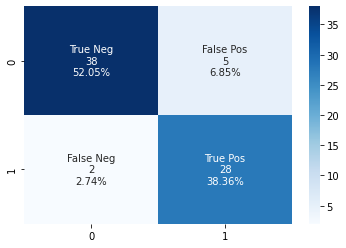

In [127]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [128]:
cm_nb = confusion_matrix(y_test, nb_ypred)
print('For Naive Bayes')
print('Confusion Matrix: ')
print(cm_nb)
acc_nb = accuracy_score(y_test, nb_ypred)
pre_nb = precision_score(y_test, nb_ypred)
rec_nb = recall_score(y_test, nb_ypred)
f1_nb = f1_score(y_test, nb_ypred)
print('Accuracy Score: ',acc_nb)
print('Precision Score: ',pre_nb)
print('Recall Score: ',rec_nb)
print('F1 Score: ',f1_nb)

For Naive Bayes
Confusion Matrix: 
[[40  3]
 [ 1 29]]
Accuracy Score:  0.9452054794520548
Precision Score:  0.90625
Recall Score:  0.9666666666666667
F1 Score:  0.9354838709677419


In [129]:
cf_matrix = np.array([[40, 3],
                     [1, 29]])

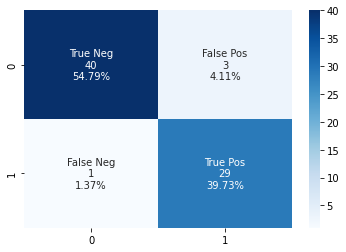

In [130]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [131]:
cm_sgd = confusion_matrix(y_test, sgd_ypred)
print('For Stochastic Gradient Descent')
print('Confusion Matrix: ')
print(cm_sgd)
acc_sgd = accuracy_score(y_test, sgd_ypred)
pre_sgd = precision_score(y_test, sgd_ypred)
rec_sgd = recall_score(y_test, sgd_ypred)
f1_sgd = f1_score(y_test, sgd_ypred)
print('Accuracy Score: ',acc_sgd)
print('Precision Score: ',pre_sgd)
print('Recall Score: ',rec_sgd)
print('F1 Score: ',f1_sgd)

For Stochastic Gradient Descent
Confusion Matrix: 
[[37  6]
 [ 1 29]]
Accuracy Score:  0.9041095890410958
Precision Score:  0.8285714285714286
Recall Score:  0.9666666666666667
F1 Score:  0.8923076923076922


In [132]:
cf_matrix = np.array([[37, 6],
                     [1, 29]])

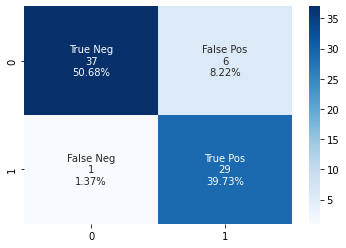

In [133]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [134]:
cm_knn = confusion_matrix(y_test, knn_ypred)
print('For KNN')
print('Confusion Matrix: ')
print(cm_knn)
acc_knn = accuracy_score(y_test, knn_ypred)
pre_knn = precision_score(y_test, knn_ypred)
rec_knn = recall_score(y_test, knn_ypred)
f1_knn = f1_score(y_test, knn_ypred)
print('Accuracy Score: ',acc_knn)
print('Precision Score: ',pre_knn)
print('Recall Score: ',rec_knn)
print('F1 Score: ',f1_knn)

For KNN
Confusion Matrix: 
[[40  3]
 [ 2 28]]
Accuracy Score:  0.9315068493150684
Precision Score:  0.9032258064516129
Recall Score:  0.9333333333333333
F1 Score:  0.9180327868852459


In [135]:
cf_matrix = np.array([[40, 3],
                     [2, 28]])

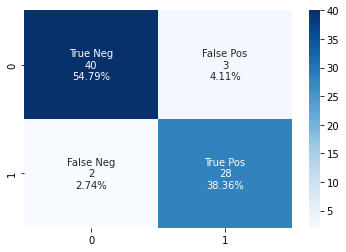

In [136]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [137]:
cm_dtree = confusion_matrix(y_test, dtree_ypred)
print('For Decision Tree')
print('Confusion Matrix: ')
print(cm_dtree)
acc_dtree = accuracy_score(y_test, dtree_ypred)
pre_dtree = precision_score(y_test, dtree_ypred)
rec_dtree = recall_score(y_test, dtree_ypred)
f1_dtree = f1_score(y_test, dtree_ypred)
print('Accuracy Score: ',acc_dtree)
print('Precision Score: ',pre_dtree)
print('Recall Score: ',rec_dtree)
print('F1 Score: ',f1_dtree)

For Decision Tree
Confusion Matrix: 
[[43  0]
 [30  0]]
Accuracy Score:  0.589041095890411
Precision Score:  0.0
Recall Score:  0.0
F1 Score:  0.0


In [138]:
cf_matrix = np.array([[43, 0],
                     [30, 0]])

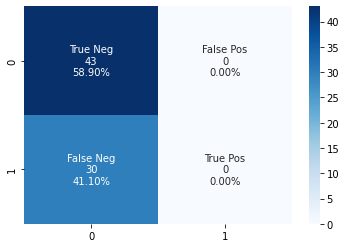

In [139]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [140]:
cm_rfm = confusion_matrix(y_test, rfm_ypred)
print('For Random Forest')
print('Confusion Matrix: ')
print(cm_rfm)
acc_rfm = accuracy_score(y_test, rfm_ypred)
pre_rfm = precision_score(y_test, rfm_ypred)
rec_rfm = recall_score(y_test, rfm_ypred)
f1_rfm = f1_score(y_test, rfm_ypred)
print('Accuracy Score: ',acc_rfm)
print('Precision Score: ',pre_rfm)
print('Recall Score: ',rec_rfm)
print('F1 Score: ',f1_rfm)

For Random Forest
Confusion Matrix: 
[[40  3]
 [ 0 30]]
Accuracy Score:  0.958904109589041
Precision Score:  0.9090909090909091
Recall Score:  1.0
F1 Score:  0.9523809523809523


In [141]:
cf_matrix = np.array([[40, 3],
                     [0, 30]])

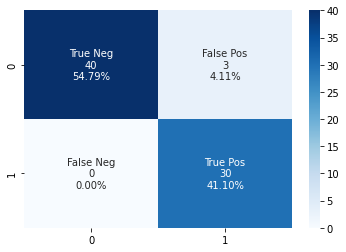

In [142]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [143]:
accuracies= {"LR": lr_acc, 
             "Naive": nb_acc, 
             "SGD": sgd_acc, 
             "kNN": knn_acc, 
             "DT": dtree_acc, 
             "RFM": rfm_acc, 
             }

precisions = {"LR": pre_lr,  
             "Naive": pre_nb, 
             "SGD": pre_sgd,
             "kNN": pre_knn, 
             "DT": pre_dtree,
            "RFM": pre_rfm,
             }

recalls = {"LR": rec_lr,  
             "Naive": rec_nb, 
             "SGD": rec_sgd,
             "kNN": rec_knn, 
             "DT": rec_dtree,
            "RFM": rec_rfm,
             }

f1s = {"LR": f1_lr,  
        "Naive": f1_nb, 
        "SGD": f1_sgd,
        "kNN": f1_knn, 
        "DT": f1_dtree,
      "RFM": f1_rfm,
        }

**Classification Evaluation Metrics**

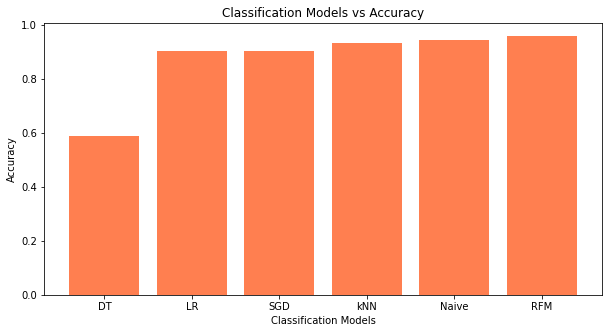

In [144]:
lists = sorted(accuracies.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(10,5))
plt.bar(*zip(*lists), color="coral")
plt.title('Classification Models vs Accuracy')
plt.xlabel('Classification Models')
plt.ylabel('Accuracy')
plt.show()

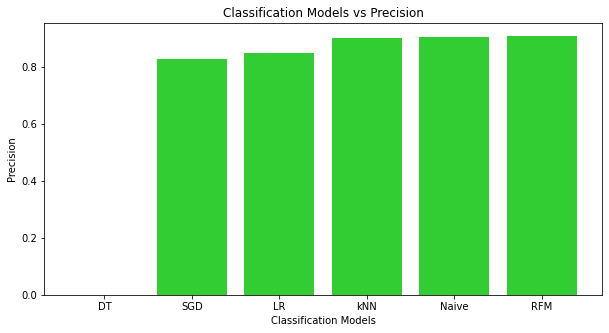

In [145]:
lists = sorted(precisions.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(10,5))
plt.bar(*zip(*lists), color="limegreen")
plt.title('Classification Models vs Precision')
plt.xlabel('Classification Models')
plt.ylabel('Precision')
plt.show()

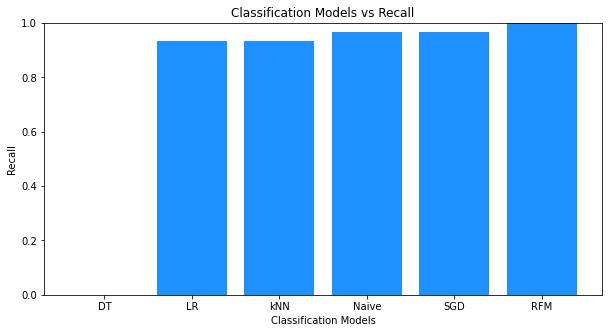

In [146]:
lists = sorted(recalls.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(10,5))
plt.bar(*zip(*lists), color="dodgerblue")
plt.ylim(0,1)
plt.title('Classification Models vs Recall')
plt.xlabel('Classification Models')
plt.ylabel('Recall')
plt.show()

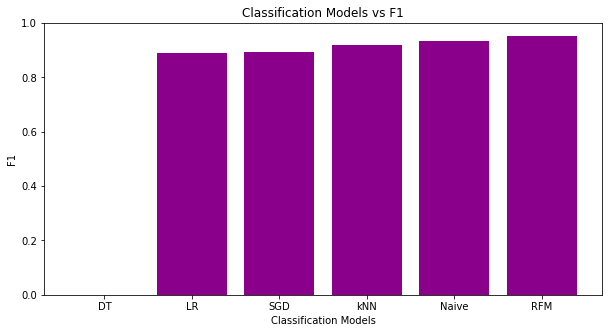

In [147]:
lists = sorted(f1s.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(10,5))
plt.bar(*zip(*lists), color="darkmagenta")
plt.title('Classification Models vs F1')
plt.xlabel('Classification Models')
plt.ylabel('F1')
plt.show()

**Apply Deep Learning Models**

In [148]:
ann_model = Sequential()
ann_model.add(Dense(units=8,activation='relu'))
ann_model.add(Dense(units=8,activation='relu'))
ann_model.add(Dense(units=8,activation='relu'))
ann_model.add(Dense(units=8,activation='relu'))
ann_model.add(Dense(units=8,activation='relu'))
ann_model.add(Dense(units=8,activation='relu'))
ann_model.add(Dense(units=8,activation='relu'))
ann_model.add(Dense(units=8,activation='relu'))
ann_model.add(Dense(units=1,activation='sigmoid'))
ann_model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
ann_model.fit(x_train,y_train,batch_size=32,epochs=100)
acc= ann_model.evaluate(x_train, y_train)
print("ANN Model Accuracy: ")
ann_acc=acc[1]
print(ann_acc*100,"%")

Epoch 1/100
6/6 [==============================] - 2s 5ms/step - loss: 0.6938 - accuracy: 0.5059
Epoch 2/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.7176
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.7471
Epoch 4/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6839 - accuracy: 0.7882
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6797 - accuracy: 0.8294
Epoch 6/100
6/6 [==============================] - 0s 5ms/step - loss: 0.6754 - accuracy: 0.8059
Epoch 7/100
6/6 [==============================] - 0s 6ms/step - loss: 0.6707 - accuracy: 0.8588
Epoch 8/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6646 - accuracy: 0.8412
Epoch 9/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6576 - accuracy: 0.8647
Epoch 10/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6496 - accuracy: 0.8529
Epoch 11/100
6/6 [===========

**Additional reshaping for CNN and LSTM**

In [149]:
x_train = np.random.uniform(0,1, (7000,10))
y_train = np.random.randint(0,2, 7000)

x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)

Convolutional Neural Networks

In [150]:
inp = Input(shape=(1,10))
conv2 = Conv1D(filters=128, kernel_size=5, activation='relu', padding='same')(inp)
drop21 = Dropout(0.5)(conv2)
conv22 = Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(drop21)
drop22 = Dropout(0.5)(conv22)
pool2 = Flatten()(drop22)
out = Dense(2, activation='softmax')(pool2)
cnn_model = Model(inp, out)
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = cnn_model.fit(x_train, y_train, epochs=100)
acc= cnn_model.evaluate(x_train, y_train)
print("CNN Model Accuracy: ")
cnn_acc=acc[1]
print(cnn_acc*100,"%")

Epoch 1/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6943 - accuracy: 0.4991
Epoch 2/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6943 - accuracy: 0.4969
Epoch 3/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5133
Epoch 4/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5099
Epoch 5/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5084
Epoch 6/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6931 - accuracy: 0.5093
Epoch 7/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6930 - accuracy: 0.5099
Epoch 8/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.5097
Epoch 9/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6926 - accuracy: 0.5141
Epoch 10/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6926 - accura

Long Short-Term Memory RNN

In [151]:
lstm_model=Sequential()
lstm_model.add(Bidirectional(LSTM(100, return_sequences=False), input_shape=(1, 10)))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(lstm_model.summary())
#history = lstm_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=20,batch_size=100)
acc= lstm_model.evaluate(x_train, y_train)
print("LSTM Model Accuracy: ")
lstm_acc=acc[1]
print(lstm_acc*100,"%")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 200)              88800     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                                 
 dense_24 (Dense)            (None, 1)                 201       
                                                                 
Total params: 89,001
Trainable params: 89,001
Non-trainable params: 0
_________________________________________________________________
None
219/219 [==============================] - 3s 3ms/step - loss: 0.6930 - accuracy: 0.5027
LSTM Model Accuracy: 
50.271427631378174 %


DL Model Evaluation

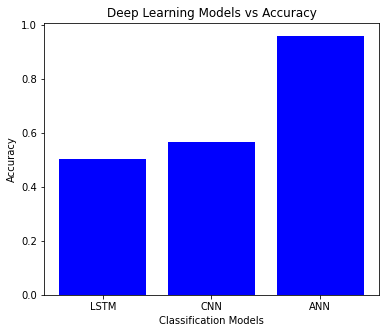

In [152]:
accuracies= {"ANN": ann_acc, 
             "CNN": cnn_acc, 
             "LSTM": lstm_acc, 
             }
lists = sorted(accuracies.items(), key=lambda x: x[1]*100)
plt.figure(figsize=(6,5))
plt.bar(*zip(*lists), color="blue")
plt.title('Deep Learning Models vs Accuracy')
plt.xlabel('Classification Models')
plt.ylabel('Accuracy')
plt.show()